Time Series Forecast with TFT on the Vierlinden dataset (all sensors, 2021)

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import torch
import numpy as np
import pickle
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar, StochasticWeightAveraging
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss, MASE
pl.seed_everything(42)

Global seed set to 42


42

### Load data

Split in train and validation

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('./RIWWER/Vierlinden/Vierlinden_2021_All.csv')

# Drop columns that have lots of missing values
data.drop(["FLP_Hohenstand_Pumpensumpf_pval","FLP_Strom_P3_pval","FLP_Strom_P4_pval","FLP_Strom_P5_pval","Durchfluss SWP1 und SWP2_pval","FLP_Hohenstand_Becken1_pval","FLP_Hohenstand_Becken3_pval","FLP_Hohenstand_Beckne2_pval"], axis=1, inplace=True)

# NaNs are not allowed by the model
data.fillna(method="bfill", inplace=True)
data.fillna(method="ffill", inplace=True)

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [3]:
# One time series for the whole year?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx
data

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Strom Pumpe 2_pval1,Strom Pumpe 3_pval,Niederschlag,Füllstand_RRB,Entleerung_RüB,Füllstand_RüB_1,Füllstand_RüB_2,Füllstand_RüB_3,series,time_idx
0,2021-01-01 00:00:00,100.0,8.140845,5.753623,7.689189,7.732558,75.717949,36.0,1.076923,0.0,...,0.0,1.0,0.000000,1.47,0.098,3.16,3.08,2.72,0,0
1,2021-01-01 01:00:00,100.0,8.000000,5.173913,6.808219,8.271739,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.099,3.16,3.08,2.72,0,1
2,2021-01-01 02:00:00,100.0,7.967742,5.000000,5.813333,7.197674,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.096,3.16,3.08,2.72,0,2
3,2021-01-01 03:00:00,100.0,7.076923,4.843750,4.216216,4.743243,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,3
4,2021-01-01 04:00:00,100.0,8.464789,5.466667,8.384615,8.325000,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,99.0,9.859155,6.147541,9.347222,12.800000,75.033333,35.0,1.700000,0.0,...,0.0,1.0,0.000000,1.06,0.181,1.15,1.29,0.62,0,8755
8756,2021-12-31 20:00:00,99.0,9.111111,5.823529,7.970588,11.211268,76.000000,35.0,1.300000,0.0,...,0.0,1.0,0.000000,1.06,0.179,1.15,1.29,0.62,0,8756
8757,2021-12-31 21:00:00,99.0,11.652778,7.544118,16.804878,17.802326,74.250000,35.0,1.600000,0.0,...,0.0,1.0,0.000000,1.06,0.183,1.15,1.29,0.62,0,8757
8758,2021-12-31 22:00:00,99.0,8.338028,5.287671,7.107692,9.878788,76.200000,35.0,1.233333,0.0,...,0.0,1.0,0.000000,1.06,0.186,1.15,1.29,0.62,0,8758


In [4]:
# Create dataloaders
max_encoder_length = 24*2
max_prediction_length = 5*2
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
# Note: if you just subtract 1*max_prediction_length, some of the time series (for some of the months) will not be computed

context_length = max_encoder_length
prediction_length = max_prediction_length

# Note: NBeats can only handle one target
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    target_normalizer="auto",
    time_idx="time_idx",
    target="Entleerung_RüB",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=list(set(data.columns) - {'Datetime', 'series', 'time_idx'}),
    time_varying_known_reals=['time_idx'],
    max_encoder_length=context_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=prediction_length,
    min_prediction_length=max_prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=18)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)

### Training

In [5]:
# Import optimal HPs from HPO notebook
with open("./RIWWER/torch_forecasting/optuna_checkpoints/TFT_Vierlinden_HPO/TFT_Vierlinden_HPO.pkl", "rb") as f:
    study = pickle.load(f)
print(study.best_trial.params)

lr   = study.best_trial.params['learning_rate']
gsv  = study.best_trial.params['gradient_clip_val']
hs   = study.best_trial.params['hidden_size']
hcs  = study.best_trial.params['hidden_continuous_size']
ahs  = study.best_trial.params['attention_head_size']
drop = study.best_trial.params['dropout']

{'gradient_clip_val': 0.203573148441866, 'hidden_size': 4, 'dropout': 0.19683012705932013, 'hidden_continuous_size': 4, 'attention_head_size': 3, 'learning_rate': 0.01513561248436208}


In [6]:
early_stop = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_sched = StochasticWeightAveraging(swa_lrs=lr, swa_epoch_start=5, device=torch.device('cuda:0'))
lr_logger = LearningRateMonitor(logging_interval='step')  # log the learning rate ('step' or 'epoch')
logger = TensorBoardLogger("./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden")  # logging results to a tensorboard
# at this path, a folder with the name lightning_logs is searched for; if not found, it is created

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=gsv,
    callbacks=[early_stop, lr_logger, TQDMProgressBar(), lr_sched],
    limit_train_batches=150,
    log_every_n_steps=5,
    logger=logger
)

net = TemporalFusionTransformer.from_dataset(
    training,
    #loss=QuantileLoss(),
    loss=MASE(),
    hidden_size=hs,
    hidden_continuous_size=hcs,
    attention_head_size=ahs,
    dropout=drop,
    learning_rate=lr,
    log_interval=10,
    log_val_interval=1,
    #weight_decay=1e-2,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    #ckpt_path="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden/lightning_logs/version_0/checkpoints/epoch=15-step=2400.ckpt"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
Missing logger folder: ./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name              

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.617


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 3.613


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.608
Swapping scheduler `ReduceLROnPlateau` for `SWALR`


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.094 >= min_delta = 0.0001. New best score: 3.514


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.163 >= min_delta = 0.0001. New best score: 3.351


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.214 >= min_delta = 0.0001. New best score: 3.136


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0001. New best score: 3.077


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0001. New best score: 3.036


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 3.036. Signaling Trainer to stop.


## TFT with QLoss

### Evaluation

In [7]:
trainer.callback_metrics

{'train_loss': tensor(0.1310),
 'train_loss_step': tensor(0.1313),
 'val_loss': tensor(0.0487),
 'val_SMAPE': tensor(0.6873),
 'val_MAE': tensor(2.6277),
 'val_RMSE': tensor(4.2043),
 'val_MAPE': tensor(8841057.),
 'train_loss_epoch': tensor(0.1310)}

In [8]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_QL/lightning_logs/version_3/checkpoints/epoch=21-step=3300.ckpt


/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [5]:
best_model = TemporalFusionTransformer.load_from_checkpoint('./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_QL/lightning_logs/version_3/checkpoints/epoch=21-step=3300.ckpt')

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [10]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_QL"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(2.6277, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


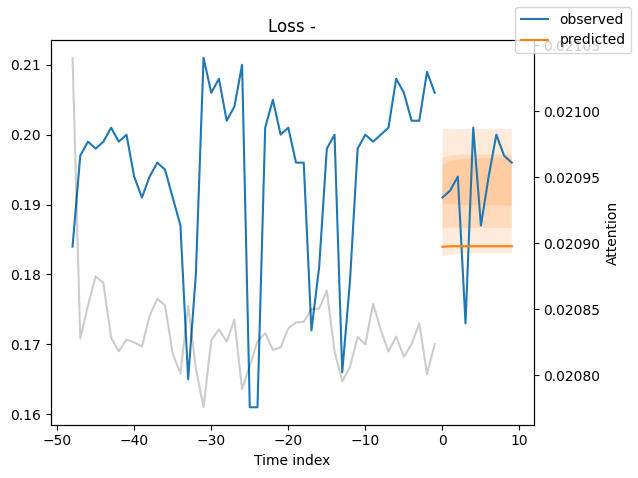

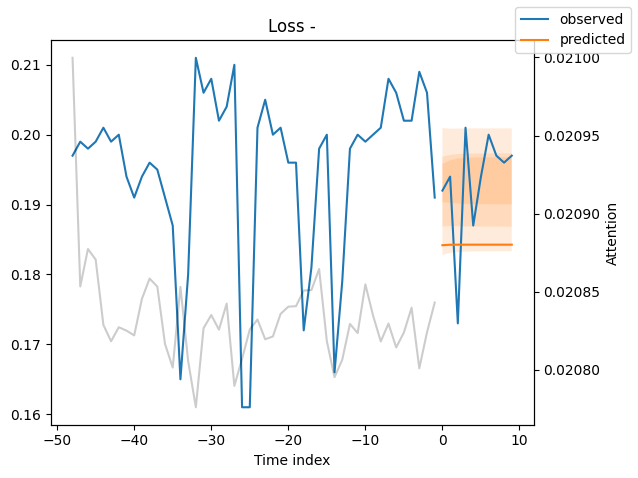

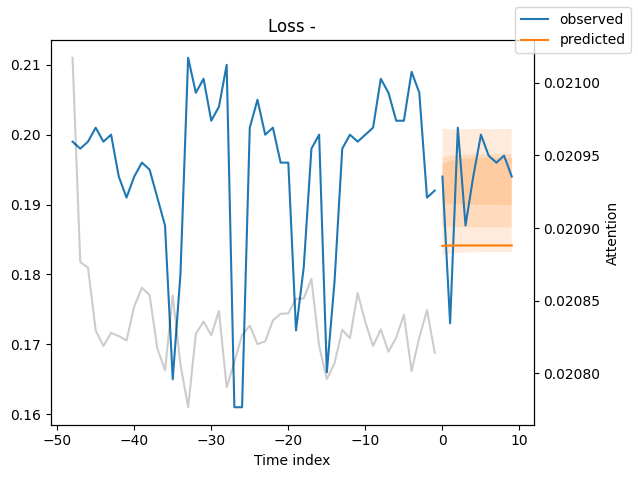

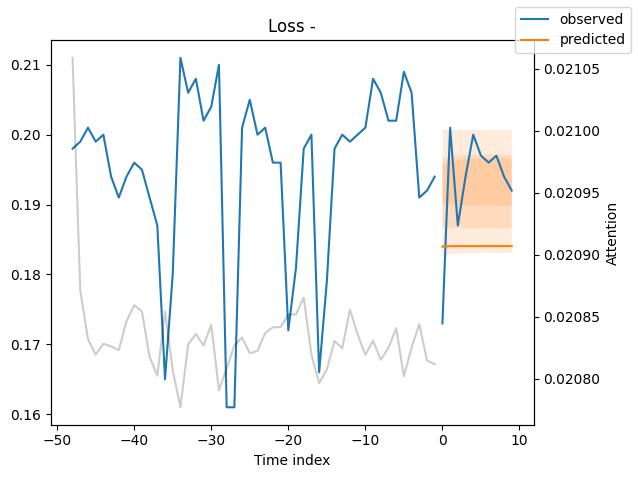

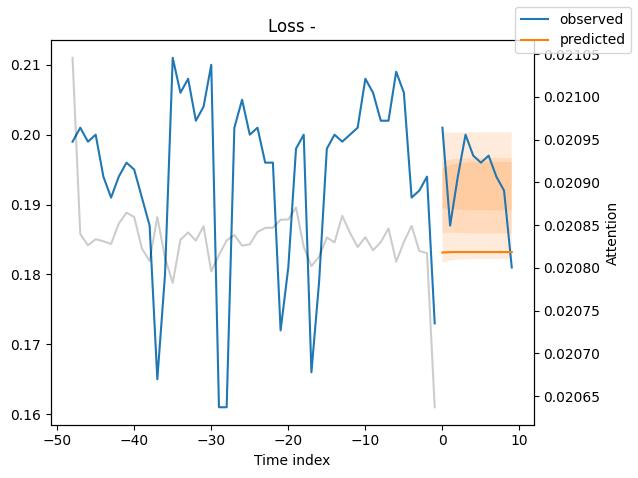

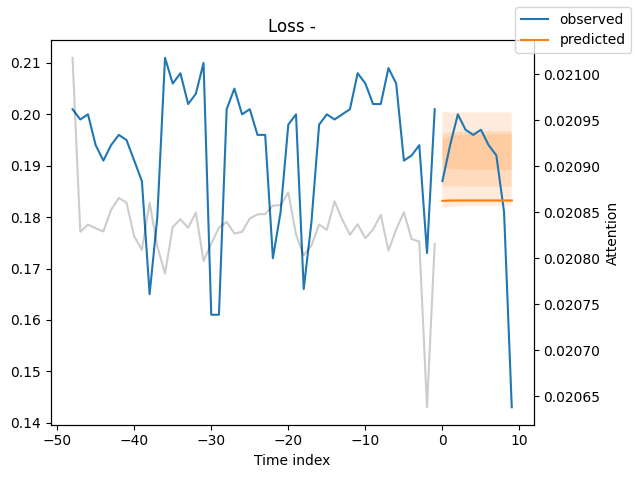

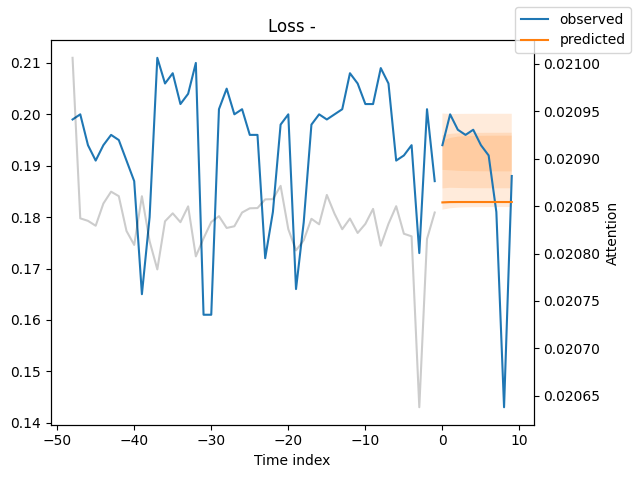

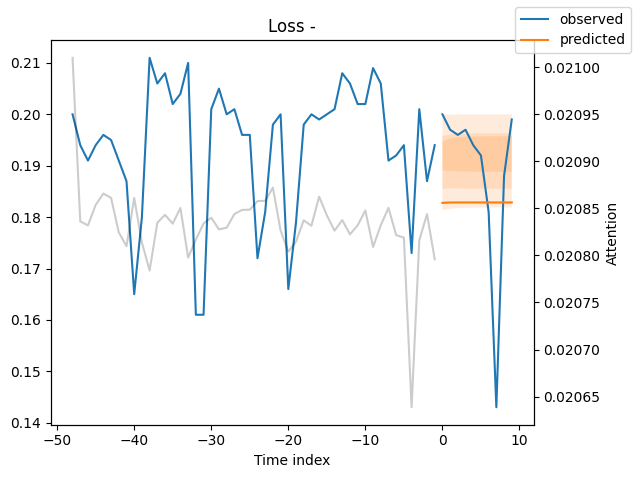

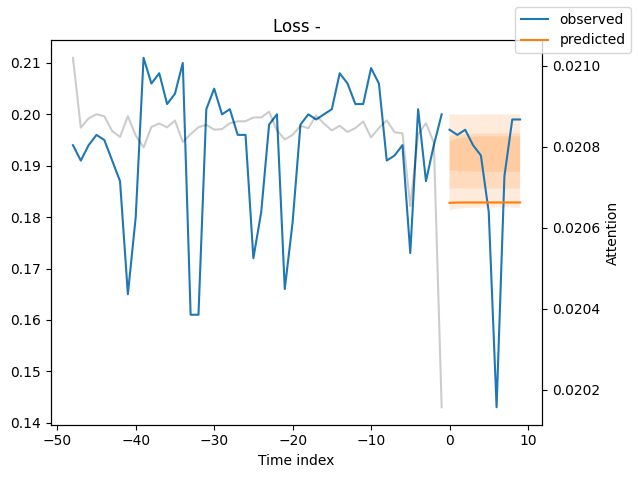

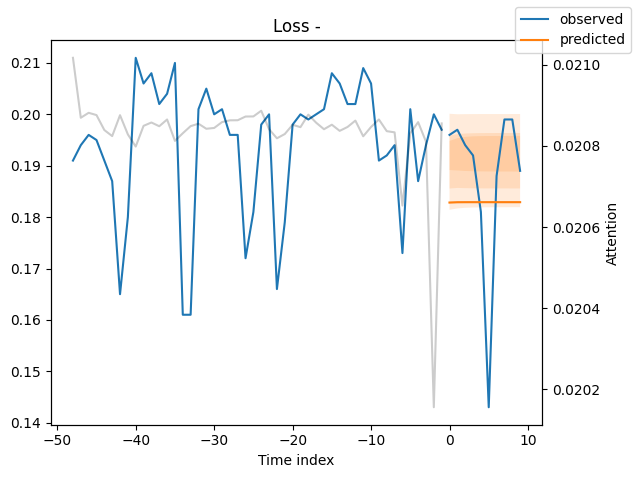

In [18]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_QL"))
for idx in range(20, 30):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

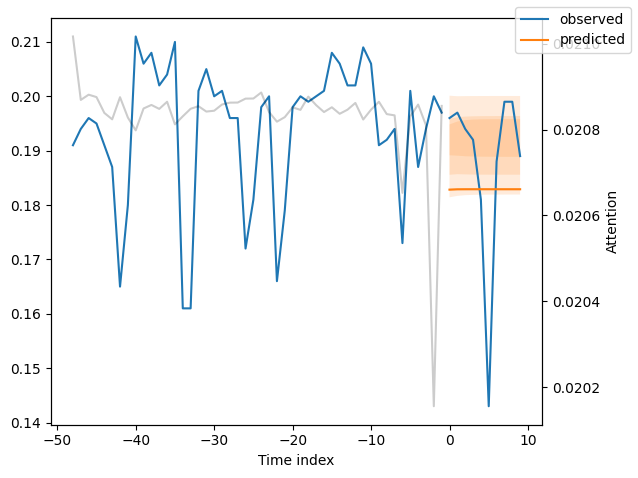

In [13]:
best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                           idx=29, add_loss_to_title=False);

### Interpretation

Variable Importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x144 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x162 with 1 Axes>}

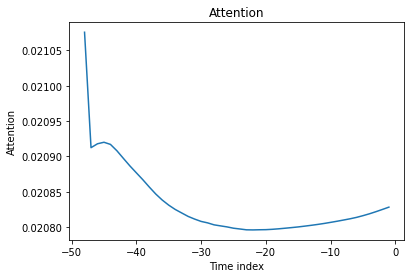

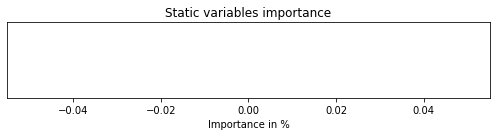

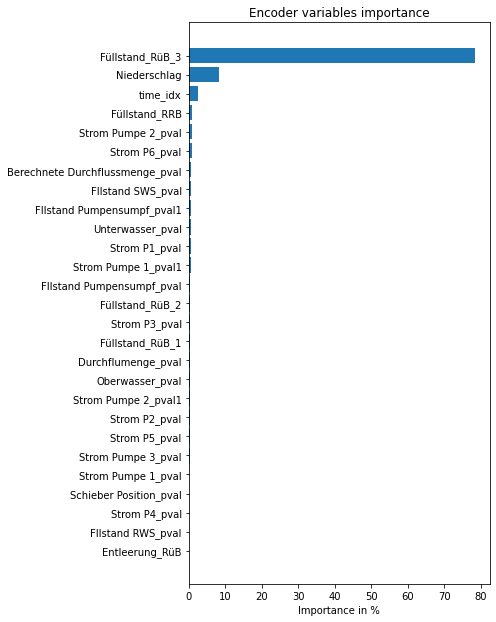

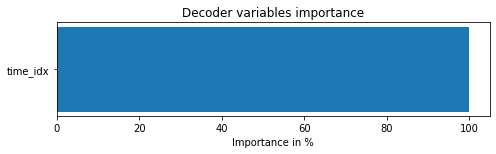

In [13]:
interpretation = best_model.interpret_output(raw_predictions.output, reduction="sum")
best_model.plot_interpretation(interpretation)

PDP

In [16]:
dependency = best_model.predict_dependency(
    val_dataloader.dataset, "Niederschlag", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but

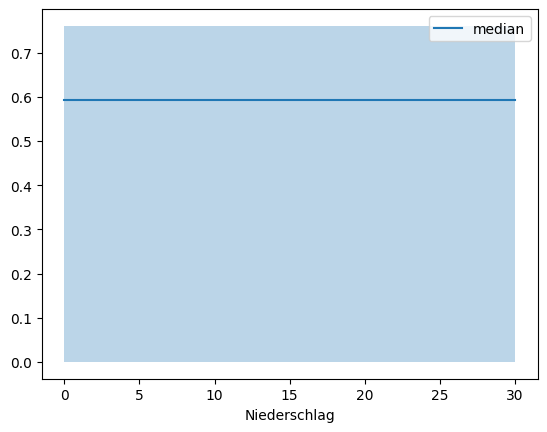

In [17]:
# Plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("Niederschlag").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)

## TFT with MASE

### Evaluation

In [7]:
trainer.callback_metrics

{'train_loss': tensor(2.5714),
 'train_loss_step': tensor(2.8496),
 'val_loss': tensor(3.4208),
 'val_SMAPE': tensor(0.5505),
 'val_MAE': tensor(1.6755),
 'val_RMSE': tensor(3.4223),
 'val_MAPE': tensor(1339824.),
 'train_loss_epoch': tensor(2.5714)}

In [8]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden/lightning_logs/version_0/checkpoints/epoch=21-step=3300.ckpt


/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [9]:
#best_model = TemporalFusionTransformer.load_from_checkpoint(...)

In [10]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.6755, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


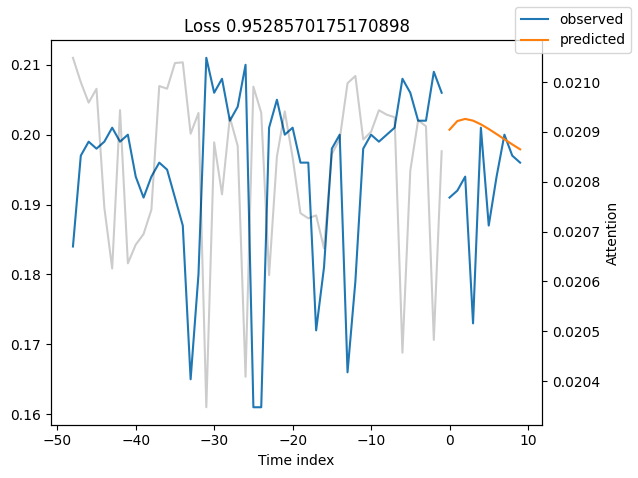

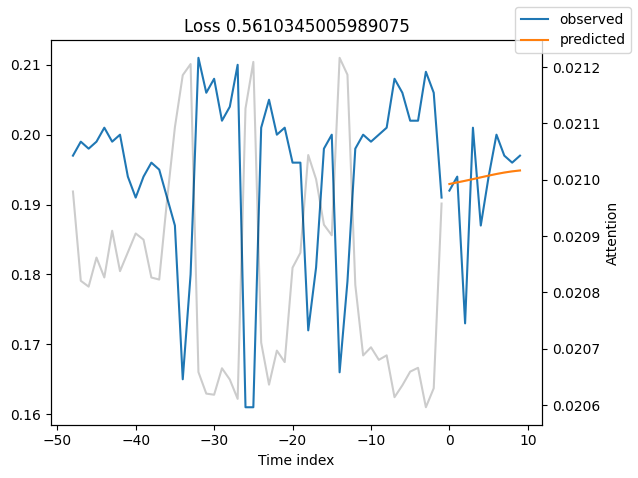

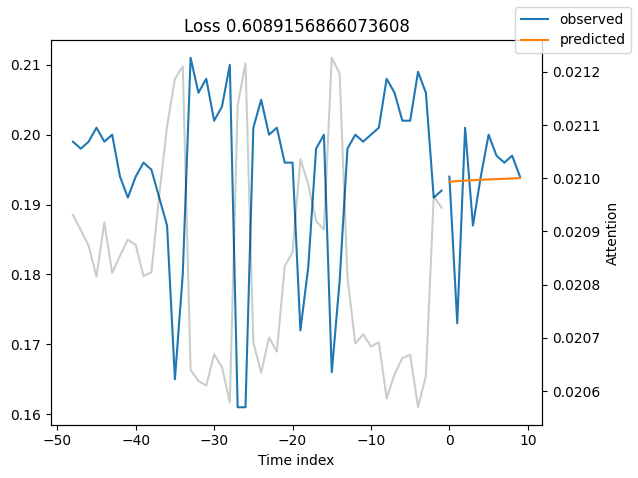

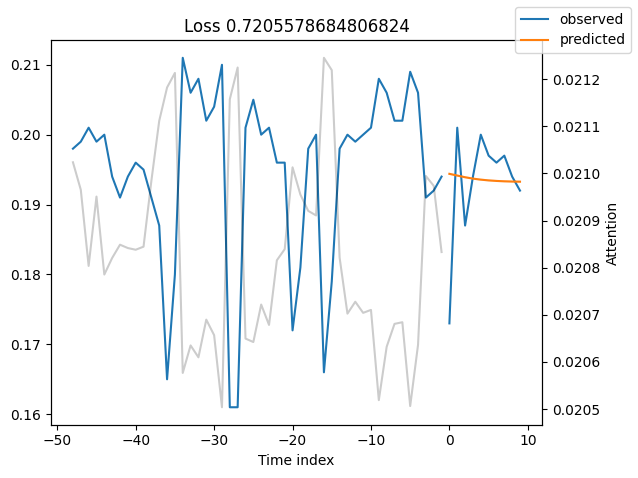

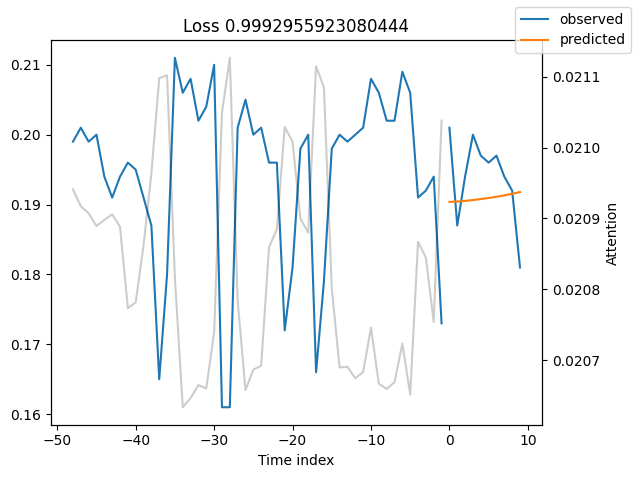

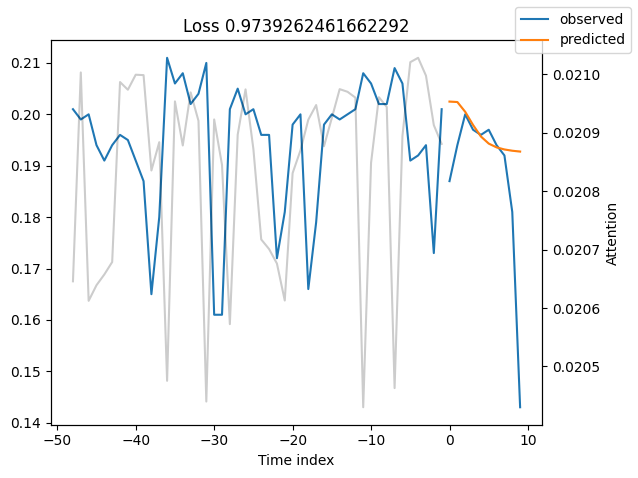

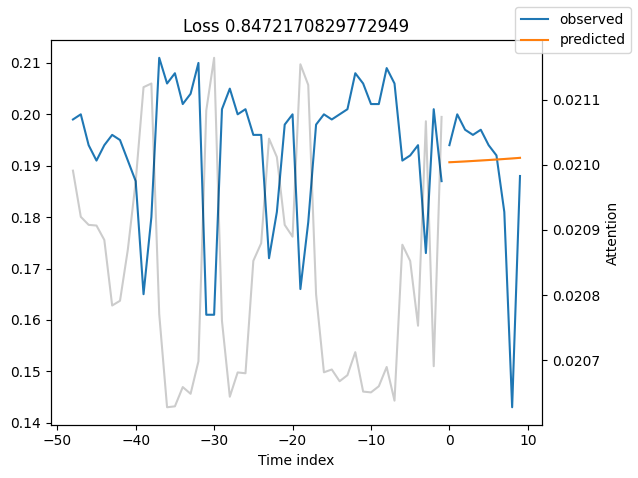

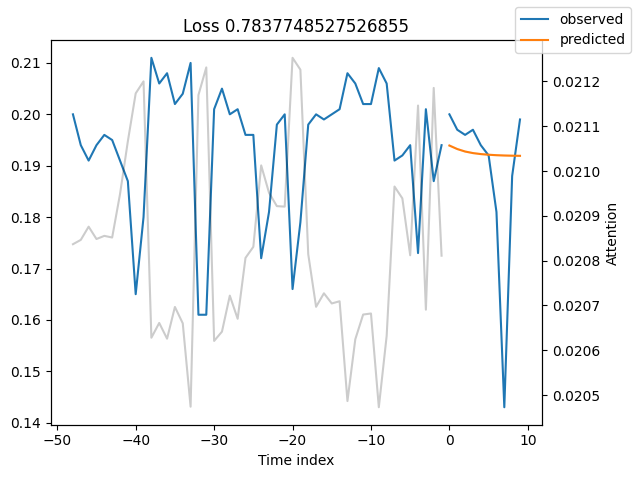

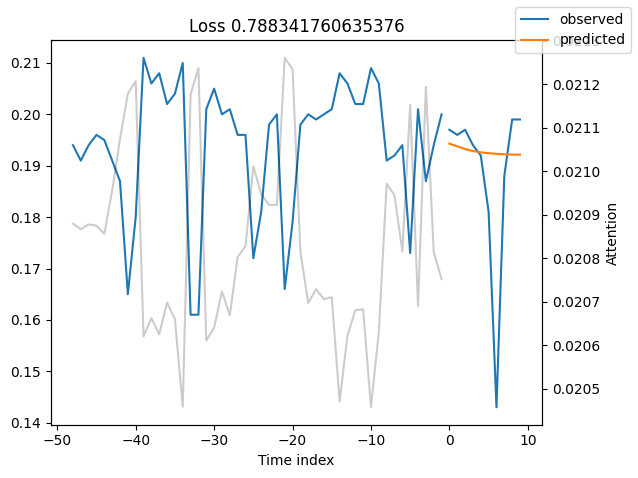

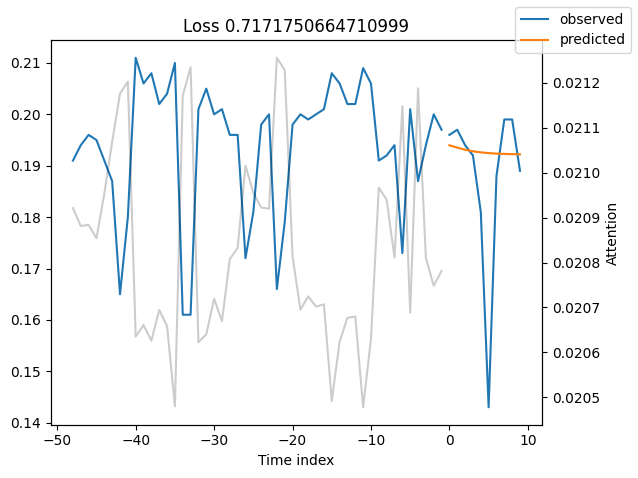

In [14]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden"))
for idx in range(20, 30):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

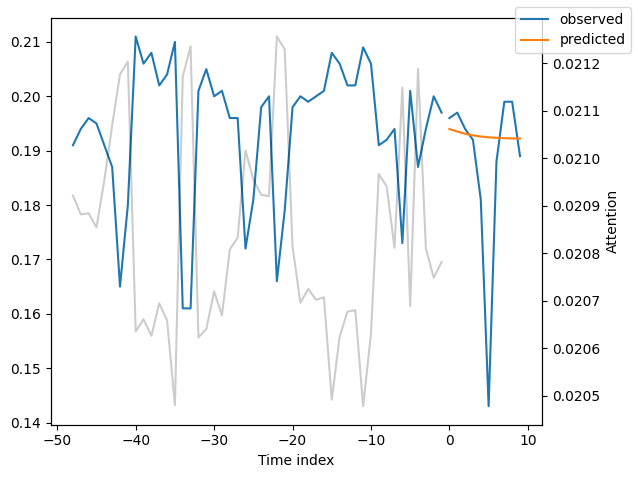

In [15]:
best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                           idx=29, add_loss_to_title=False);

### Interpretation

Variable Importances

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x875 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

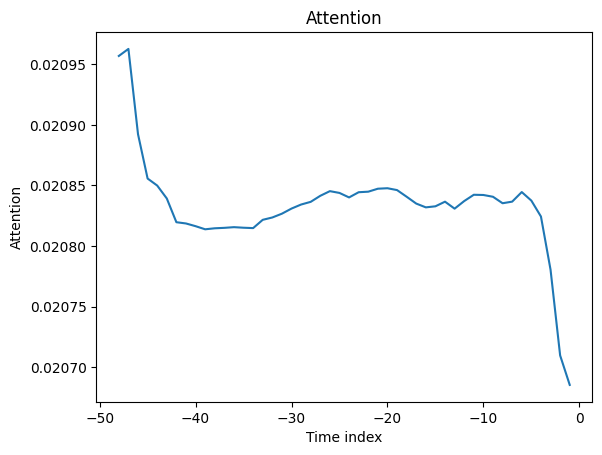

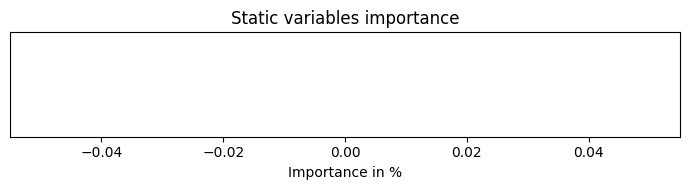

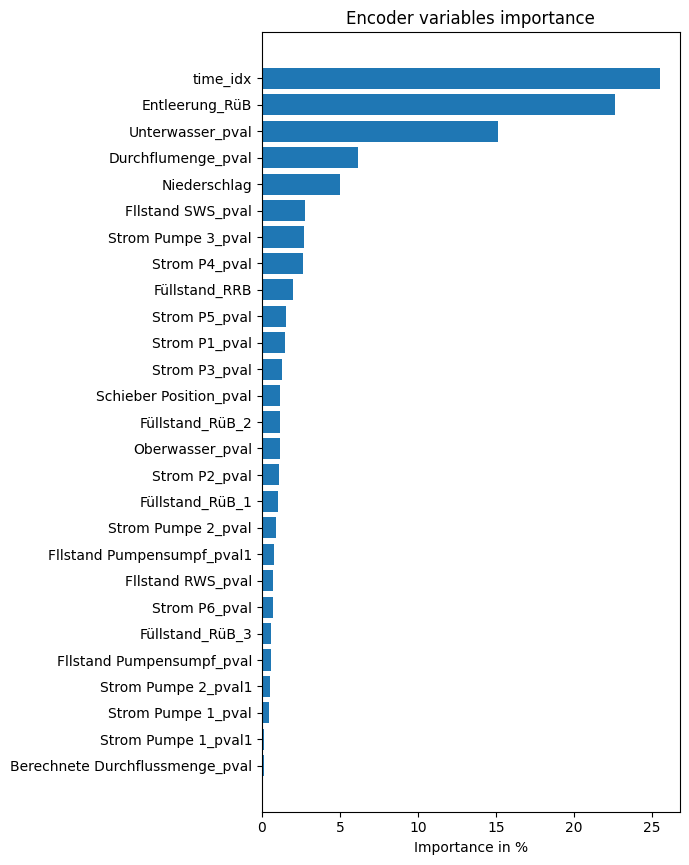

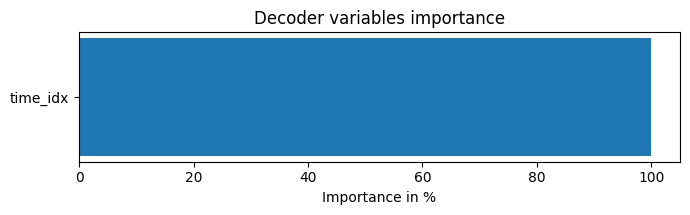

In [16]:
interpretation = best_model.interpret_output(raw_predictions.output, reduction="sum")
best_model.plot_interpretation(interpretation)

PDP

In [18]:
dependency = best_model.predict_dependency(
    val_dataloader.dataset, "Unterwasser_pval", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but

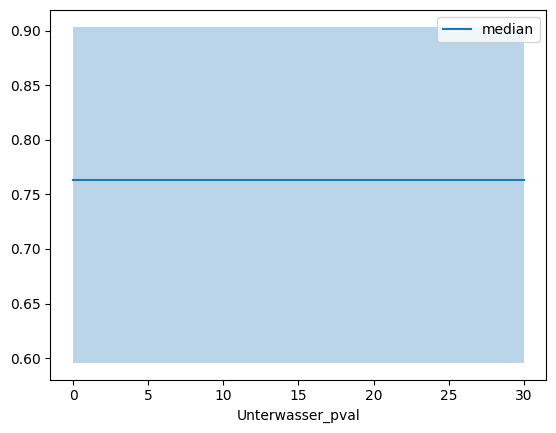

In [19]:
# Plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("Unterwasser_pval").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)